# Step 1: Load and Preprocess Images

In [1]:
logs = [
    "log-20240306-043751",
    "log-20240313-102003",
    "log-20240313-114736",
    "log-20240313-160024",
    "log-20240313-171514",
    "log-20240313-183846",
    "log-20240313-200023",
    "log-20240313-212328",
    "log-20240313-224845",
    "log-20240314-000952",
    "log-20240314-120037",
    "log-20240314-132530",
    "log-20240314-144706",
    "log-20240314-160643",
    "log-20240314-172950",
    "log-20240314-184518",
    "log-20240315-095536",
    "log-20240315-111916",
    "log-20240316-033024",
    "log-20240316-063932",
    "log-20240316-080533",
    "log-20240316-093331",
    "log-20240316-105445",
    "log-20240316-122134",
    "log-20240316-150957",
    "log-20240316-163235",
    "log-20240316-175351",
    "log-20240316-192406",
    "log-20240317-040558",
    "log-20240317-053257",
    "log-20240317-065118",
    "log-20240317-080313",
    "log-20240317-104931"
]

categories = [
    "B", "B", "B", "B", "A", "A", "B", "A", "A", "B", "B", "B", "B", "B", "A", "A", 
    "B", "B", "B", "B", "B", "B", "A", "B", "A", "B", "B", "A", "B", "A", "B", "A", "B"

]

# Create a dictionary mapping log entries to their categories
log_mapping = {log: category for log, category in zip(logs, categories)}

print(log_mapping["log-20240317-104931"])


B


In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

folder_path = 'Data/Mode Multiplexers/bitmap'
images = []
labels = []
for filename in os.listdir(folder_path):
    if filename.endswith(".bmp"):
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        image = image.convert('L')
        image = image.resize((128,128))
        image_array = np.array(image)
        images.append(image_array[33:96,33:96])
        if log_mapping[filename[:-4]] == 'A':
            labels.append(0);
        else:
            labels .append(1)
        
labels = np.array(labels)
images = np.array(images)
images = images / 255.0
images = np.expand_dims(images, axis=-1)
print("Total images loaded and preprocessed:", len(images))

Total images loaded and preprocessed: 33


# Step 2: Create binary classification model

In [3]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras import layers

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=16)
model = Sequential()
# First convolutional block with Depthwise Separable Convolutions
model.add(layers.Conv2D(16, (3, 3), padding='same', input_shape=(63, 63, 1)))
model.add(layers.SeparableConv2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), padding='same'))

# Second convolutional block
model.add(layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), padding='same'))

# Third convolutional block
model.add(layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())

# Global Average Pooling
model.add(layers.GlobalAveragePooling2D())

# Fully connected layer with Dropout
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 63, 63, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 63, 63, 16)     │           416 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 32, 32, 32)     │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 16, 16, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 16, 16, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,001 (101.57 KB)

 Trainable params: 25,649 (100.19 KB)

 Non-trainable params: 352 (1.38 KB)

# Step 3: Train model

In [5]:
import sys
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
dataset = tf.data.Dataset.from_tensors((X_train, y_train))
# Define the callbacks for early stopping of model based on val loss change.
tf.random.set_seed(0)
early_stopping = [EarlyStopping(monitor = 'val_loss', min_delta =  0.01, patience = 3)]
# Fitting the CNN
model.fit(dataset, epochs=60, callbacks = early_stopping)


Epoch 1/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - acc: 0.5833 - loss: 0.6968
Epoch 2/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.5833 - loss: 0.6896
Epoch 3/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.7083 - loss: 0.6668
Epoch 4/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.7500 - loss: 0.6509
Epoch 5/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.6667 - loss: 0.6404
Epoch 6/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.6250 - loss: 0.6425
Epoch 7/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.6250 - loss: 0.6301
Epoch 8/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.6250 - loss: 0.6324
Epoch 9/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6250 - loss: 0.6299
Epoch 10/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.6250 - loss: 0.6132
Epoch 11/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.6250 - loss: 0.6117
Epoch 12/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.6250 - loss: 0.6026
Epoch 13/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.6250

In [7]:
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from lime import lime_image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import imageio
import os
import PIL
import cv2

100%|██████████| 1000/1000 [00:03<00:00, 276.37it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
100%|██████████| 1000/1000 [00:03<00:00, 267.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
100%|██████████| 1000/1000 [00:03<00:00, 292.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
100%|██████████| 1000/1000 [00:03<00:00, 289.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
100%|██████████| 1000/1000 [00:03<00:00, 282.08it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
100%|██████████| 1000/1000 [00:03<00:00, 300.58it/s]
Clipping inp

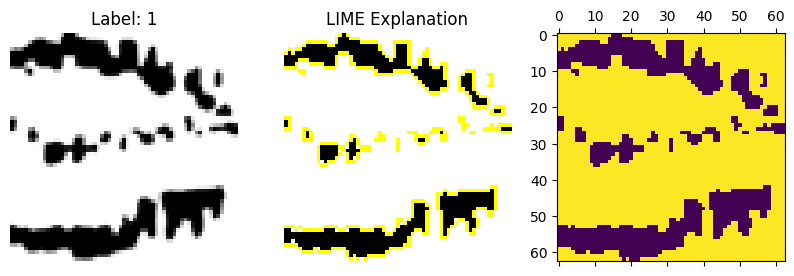

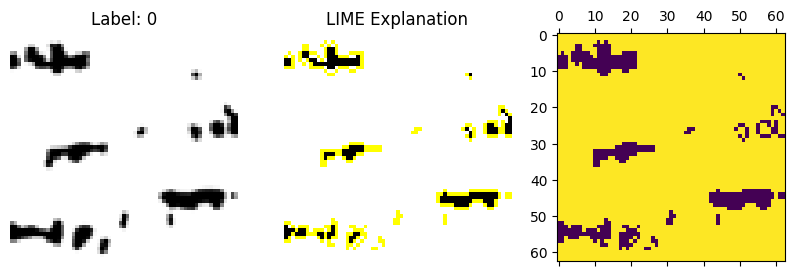

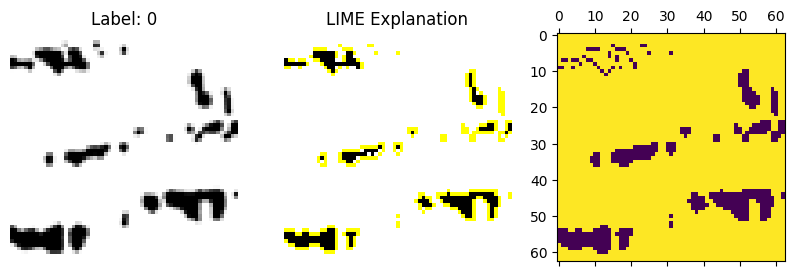

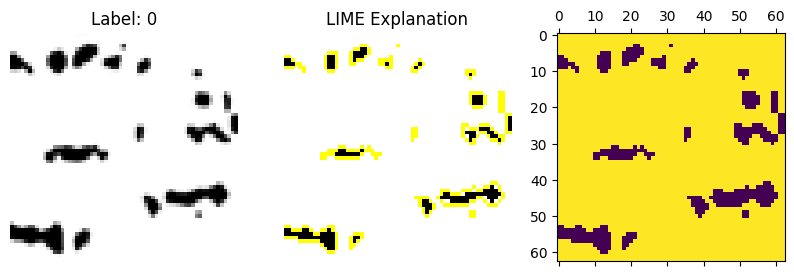

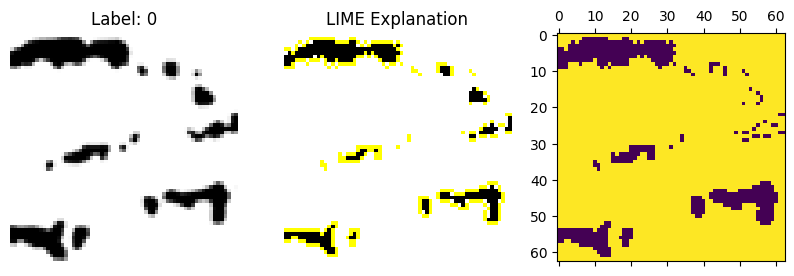

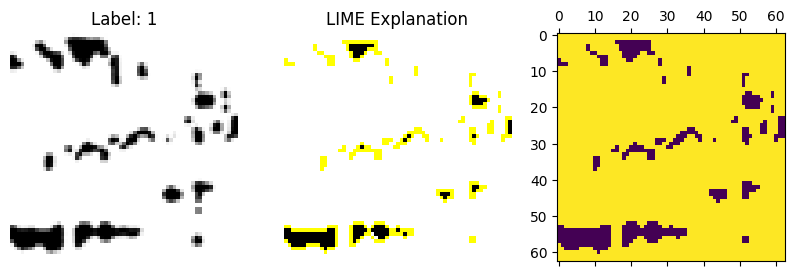

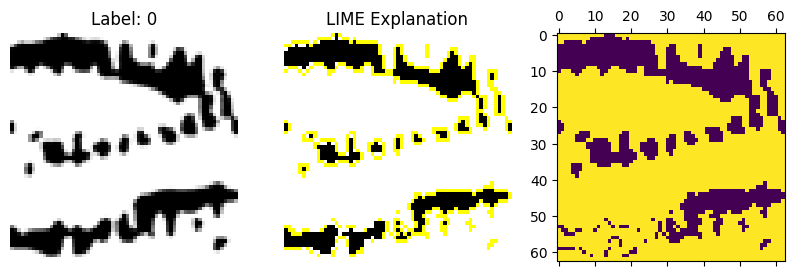

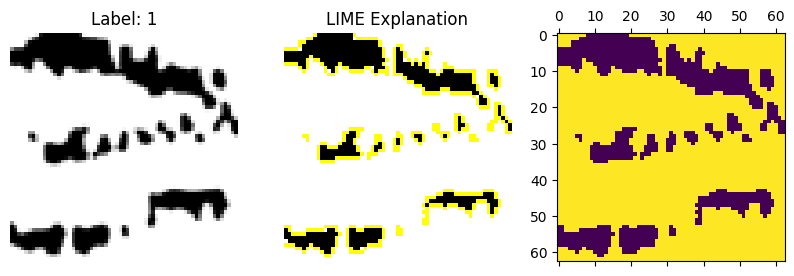

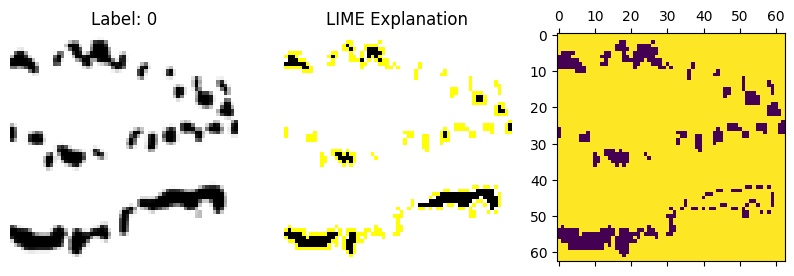

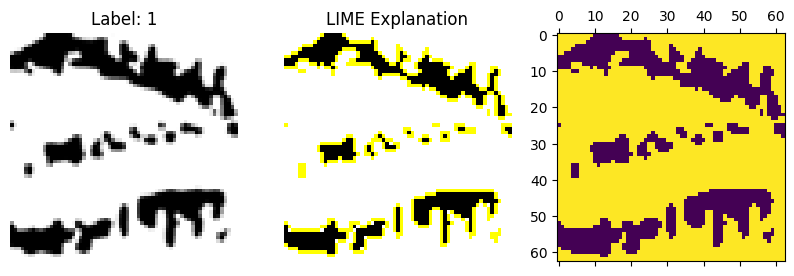

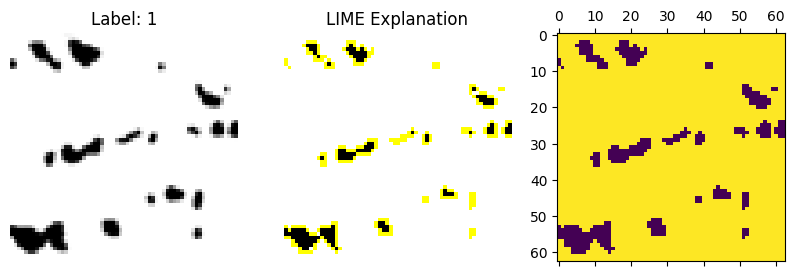

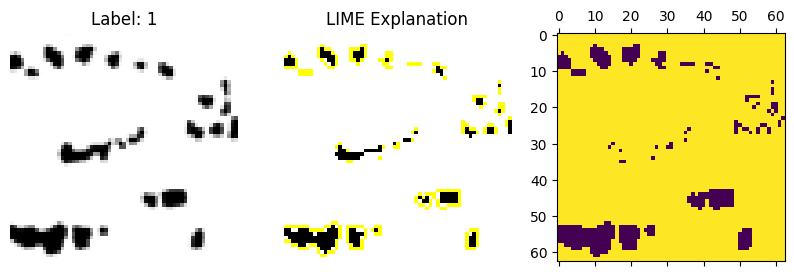

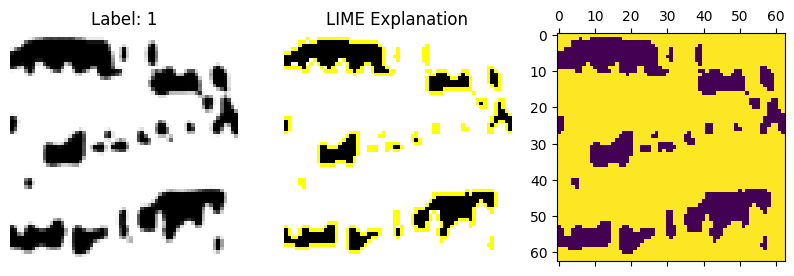

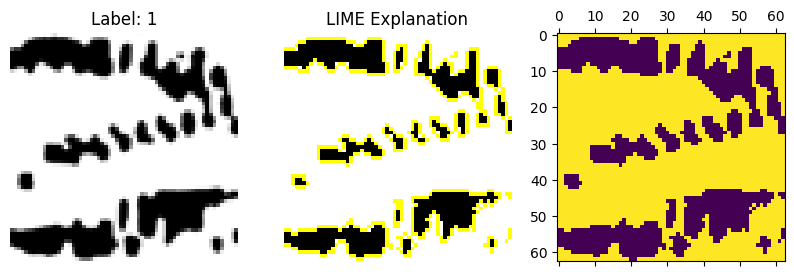

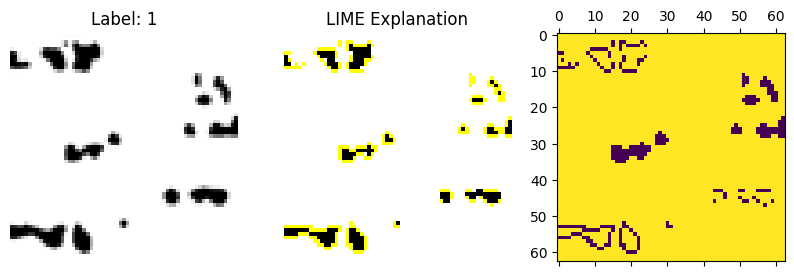

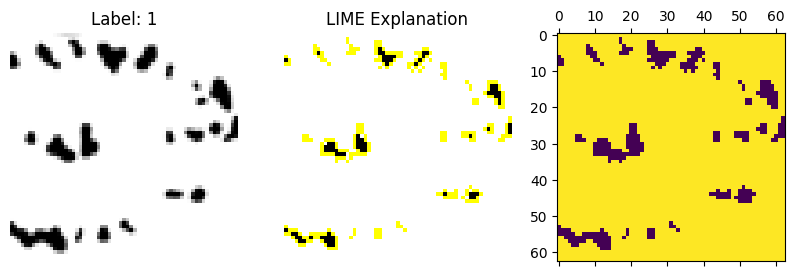

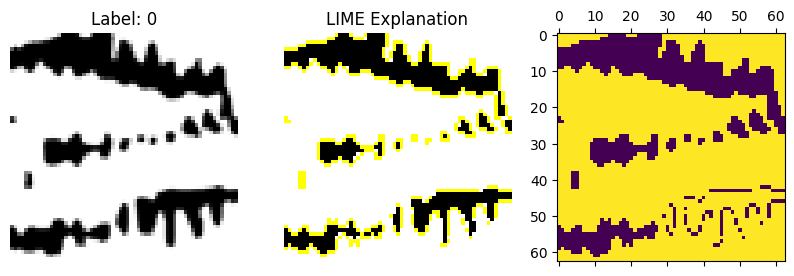

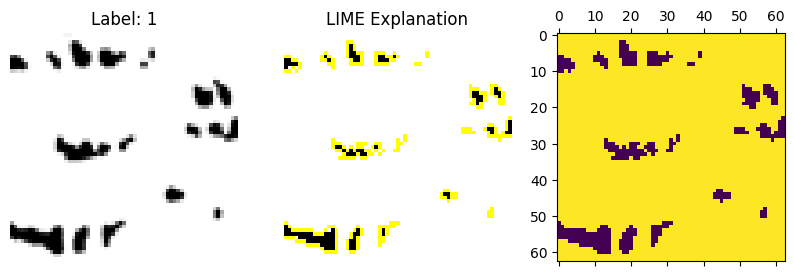

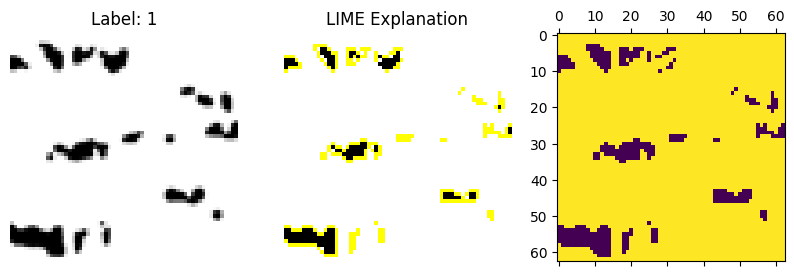

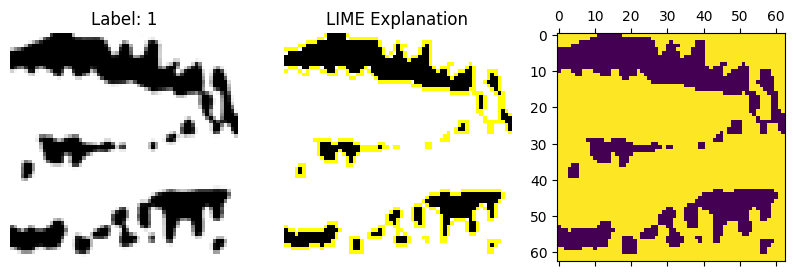

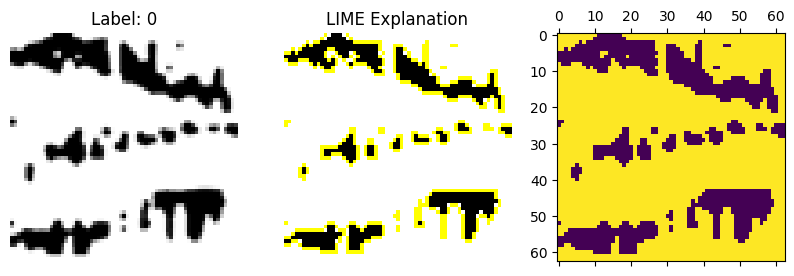

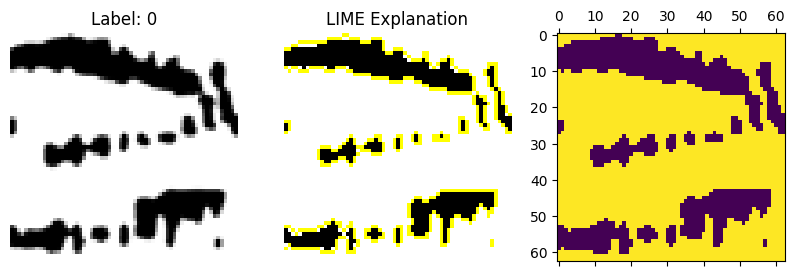

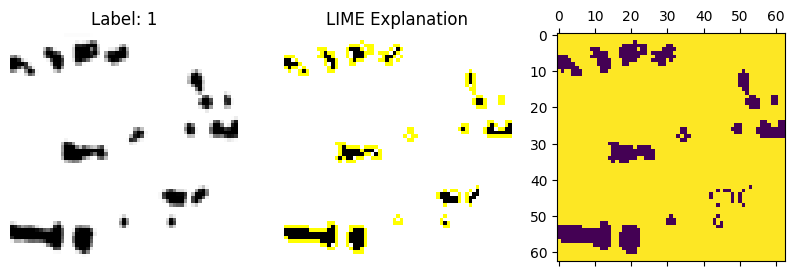

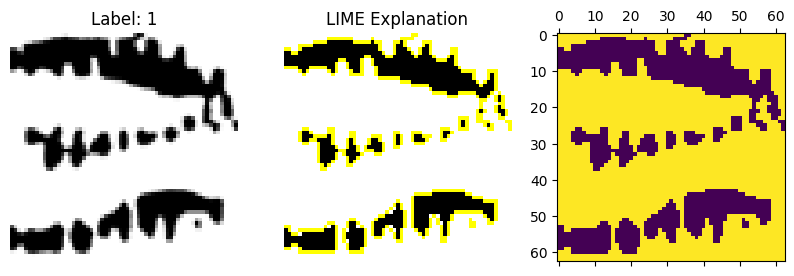

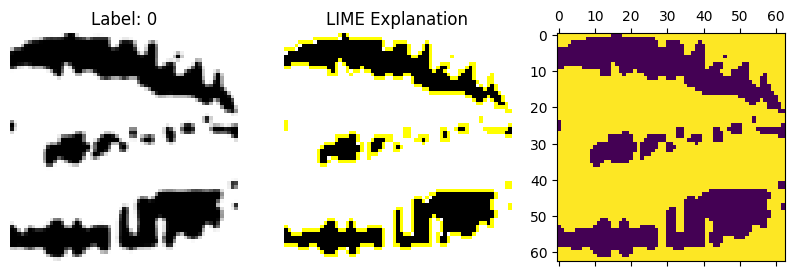

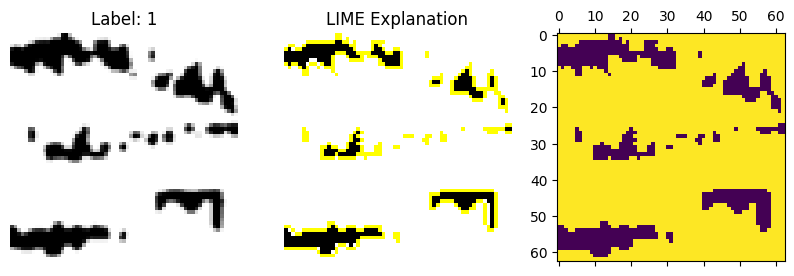

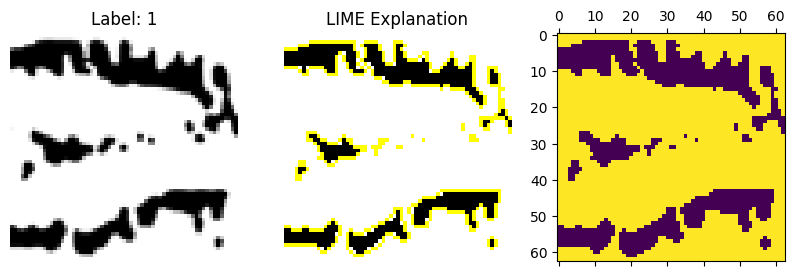

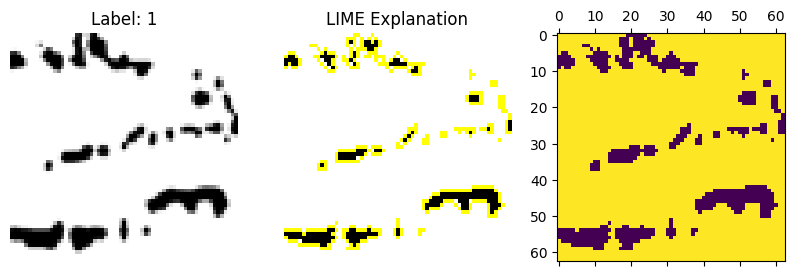

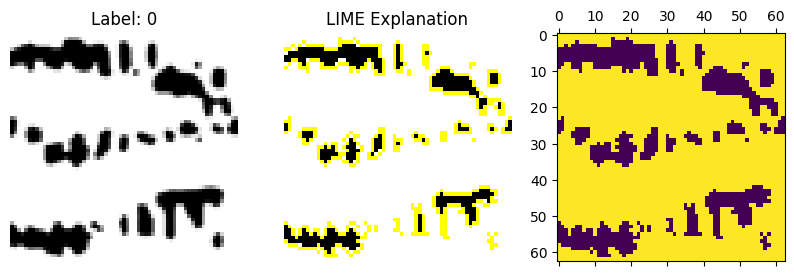

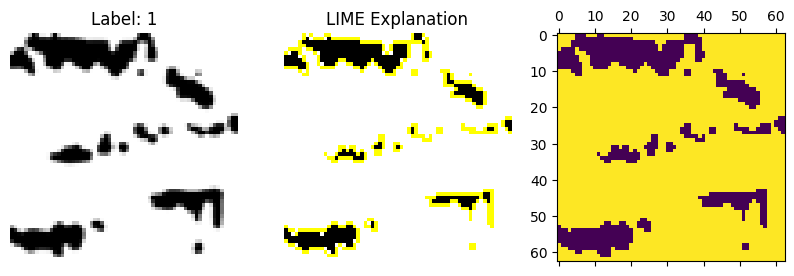

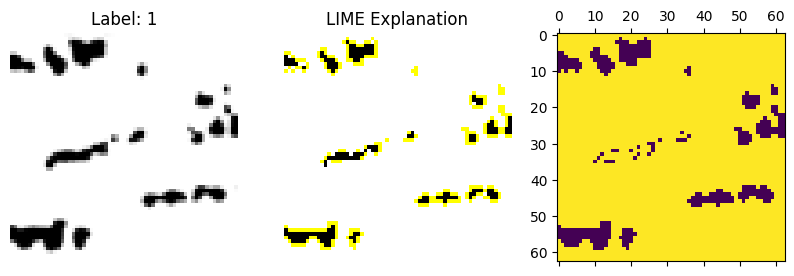

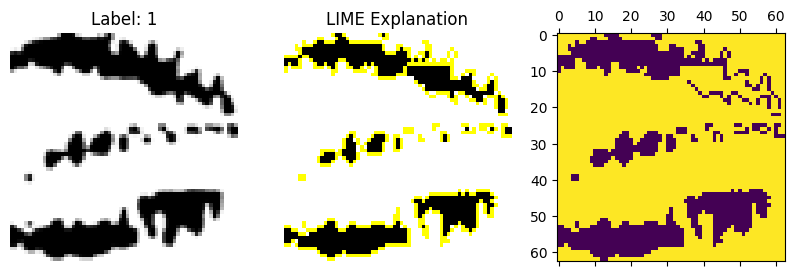

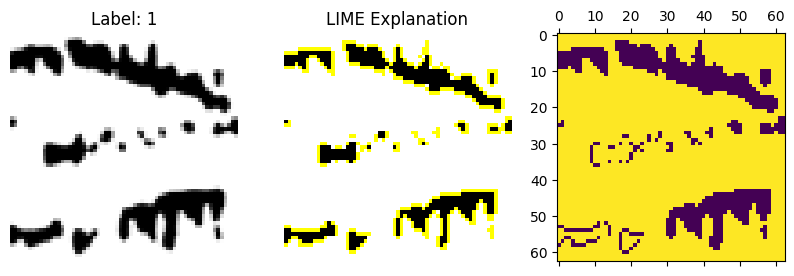

In [8]:
from skimage.segmentation import mark_boundaries

def predict_fn(images):
    images = images[:,:,:,0] # Extract the first channel if images are RGB
    images = images.reshape(images.shape[0], 63,63, 1) # Reshape to match autoencoder input
    features = model.predict(images)
    return features.reshape(features.shape[0], -1) # Reshape to (num_samples, num_features)

explainer = lime_image.LimeImageExplainer()
i = 0

for image in images:
  sample_image = cv2.cvtColor((image.reshape(63,63, 1) * 255).astype('uint8'), cv2.COLOR_GRAY2RGB)
  with SuppressOutput():
    explanation = explainer.explain_instance(
        sample_image.astype('double'),
        predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Get the image and mask for the top label
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

  # Display the original image and the LIME explanation
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
  ax1.imshow(sample_image[:,:,0].reshape(63, 63), cmap='gray')
  ax1.set_title("Label: " + str(labels[i]))
  ax1.axis('off')

  ax2.imshow(mark_boundaries(temp, mask))
  ax2.set_title('LIME Explanation')
  ax2.axis('off')

  ax3.matshow(mask)
  i+=1

plt.show()